# Playground: Lagrangian classical mechanics

In [354]:
using Symbolics
using ModelingToolkit
using OrdinaryDiffEq
using Plots
using LinearAlgebra: dot 
using Symbolics: derivative

plotlyjs()

Plots.PlotlyJSBackend()

Dampened harmonic oscillator with Sinusoidal driving force:
$$
\frac{\mathrm{d}^{2} x}{\mathrm{d} t^{2}} + 2 \zeta \omega_{0} \frac{\mathrm{d} x}{\mathrm{d} t} + \omega_{0}^2 x = \frac {1}{m} F_0 \sin(\omega t),
$$
where
- $F_{0}$ is the driving amplitude,
- $\omega$ is the driving frequency for a sinusoidal driving mechanism
- $\omega _{0}$ undamped angular frequency

Steady state solution:
The steady-state solution is proportional to the driving force with an induced phase change {\displaystyle \varphi }\varphi :

$$
x(t) = \frac{F_0}{m Z_m \omega} \sin(\omega t + \varphi),
$$
where

- $ Z_m = \sqrt{\left( 2 \omega_{0} \zeta \right)^2 + \frac{1}{\omega^2}\left(\omega_0^2 - \omega^2 \right)^2 } $ is the absolute value of the impedance or linear response function, and
- $ \varphi = \arctan\left(\frac{2 \omega \omega_0 \zeta}{\omega^2 - \omega_0^2} \right) + n \pi $ is the phase of the oscillation relative to the driving force. 

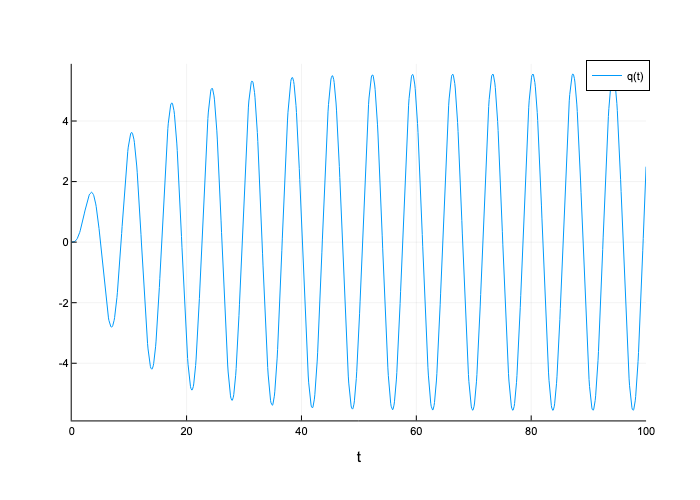

In [355]:
@variables t q(t)  # independent and dependent variables
@parameters ω m F₀ ω₀ ζ  # parameters

D = Differential(t); # define an operator for the differentiation w.r.t. time

eqs = [D(D(q)) ~ 1 / m * F₀ * sin(ω * t) - 2 * ζ * ω₀ * D(q) - ω^2 * q,]

@named sys = ODESystem(eqs)
# structural_simplify(sys)
sys = ode_order_lowering(sys)

tspan = (0., 100.)

prob = ODEProblem(sys, [0., 0.0], tspan, [ω=>.9, m=>1., F₀=>1., ω₀=>1., ζ=>.1])
sol = solve(prob)

# plot(sol,linewidth=2,title ="Driven harmonic oscillator", xaxis = "Time", yaxis = "Amplitude", label = ["q" "dq"])
plot(sol,  vars=[q])

In [2]:
function steady_state(p, t)
    ω, m, F₀, ω₀, ζ = p
    Zm = sqrt((2*ω₀*ζ)^2 + 1/ω^2*(ω₀^2-ω^2)^2)
    # @show Zm
    # @show F₀/(m*Zm*ω)
    phi = atan(2*ω*ω₀*ζ/(ω^2-ω₀^2))
    return F₀/(m*Zm*ω) * sin(ω * t + phi)
end

function steady_state_amplitude(p)
    ω, m, F₀, ω₀, ζ = p
    Zm = sqrt((2*ω₀*ζ)^2 + 1/ω^2*(ω₀^2-ω^2)^2)
    return F₀/(m*Zm*ω) 
end

# steady_state(p, t::AbstractArray)

steady_state_amplitude (generic function with 1 method)

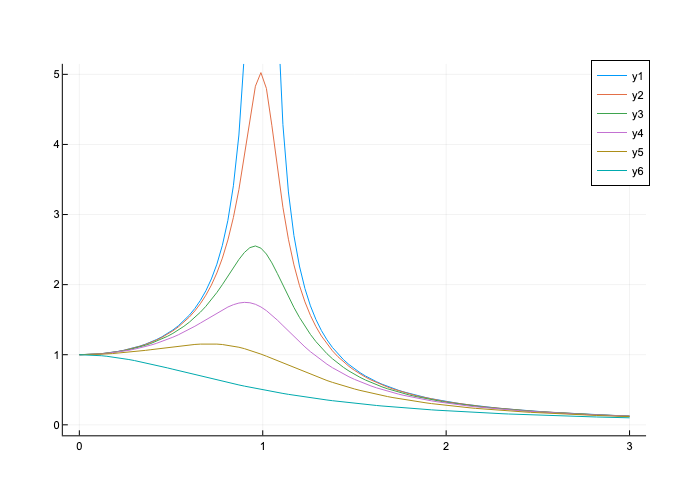

In [403]:
omega_range = LinRange(0.001, 3, 101)
zeta_range = [0., .1, .2, .3, .5, 1.]

# frequency shifting
# omega_r = ω₀ * sqrt(1 - 2 * ζ^2)    
# ω, m, F₀, ω₀, ζ = p

d = [[steady_state_amplitude([omega, 1., 1., 1., zeta]) for omega in omega_range] for zeta in zeta_range]
plot(omega, d, ylims=[0,5])

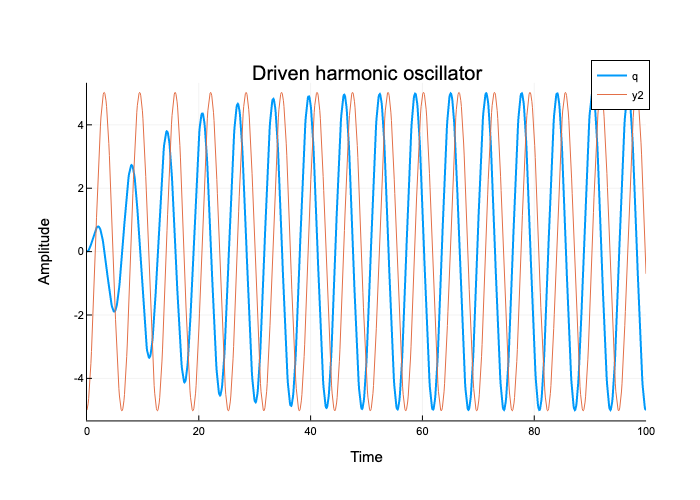

In [423]:
function drivenoscillator(du, u, p, t)
    q, dq  = u            # variables
    ω, m, F₀, ω₀, ζ = p   # parameters
    du[1] = dq
    du[2] = 1 / m * F₀ * sin(ω * t) - 2 * ζ * ω₀ * dq - ω^2 * q
end

# Initial Conditions
u₀ = [0, 0]

tspan = (0., 100.)

# Parameters
p = [.99, 1., 1., 1., .1]

# Pass to solvers
prob = ODEProblem(drivenoscillator, u₀, tspan, p)
sol = solve(prob, Tsit5())


# Plot
# plot(sol,linewidth=2,title ="Driven harmonic oscillator", xaxis = "Time", yaxis = "Amplitude", label = ["q" "dq"])
plot(sol, linewidth=2, title="Driven harmonic oscillator", xaxis="Time", yaxis="Amplitude", vars=[2,], label="q")

# plot(sol)
t = LinRange(tspan..., 1000)
plot!(t, [steady_state(p, ti) for ti in t])

## 	Universal oscillator equation

The equation 
$$
\frac{\mathrm{d}^2q}{\mathrm{d} \tau^2} + 2 \zeta \frac{\mathrm{d}q}{\mathrm{d}\tau} + q = 0
$$

is known as the "universal oscillator equation", since all second-order linear oscillatory systems can be reduced to this form. This is done through nondimensionalization.

If the forcing function is $ f(t) = cos(\omega t) = cos(\omega t_c \tau) = cos(\omega \tau)$, where $\omega = \omega t_c$, the equation becomes

$$
\frac{\mathrm{d}^2q}{\mathrm{d} \tau^2} + 2 \zeta \frac{\mathrm{d}q}{\mathrm{d}\tau} + q = \cos(\omega \tau).
$$

The solution to this differential equation contains two parts: the "transient" and the "steady-state".

### Transient solution

The solution based on solving the ordinary differential equation is for arbitrary constants $c_1$ and $c_2$

$$
q_t (\tau) = \begin{cases}
 \mathrm{e}^{-\zeta\tau} \left( c_1 \mathrm{e}^{\tau \sqrt{\zeta^2 - 1}} + c_2 \mathrm{e}^{- \tau \sqrt{\zeta^2 - 1}} \right) & \zeta > 1 \text{ (overdamping)} \\
 \mathrm{e}^{-\zeta\tau} (c_1+c_2 \tau) = \mathrm{e}^{-\tau}(c_1+c_2 \tau) & \zeta = 1 \text{ (critical damping)} \\
 \mathrm{e}^{-\zeta \tau} \left[ c_1 \cos \left(\sqrt{1-\zeta^2} \tau\right) + c_2 \sin\left(\sqrt{1-\zeta^2} \tau\right) \right] & \zeta < 1 \text{ (underdamping)}
\end{cases}
$$

The transient solution is independent of the forcing function.

### Steady-state solution
Apply the "complex variables method" by solving the auxiliary equation below and then finding the real part of its solution:
$$
\frac{\mathrm{d}^2 q}{\mathrm{d}\tau^2} + 2 \zeta \frac{\mathrm{d}q}{\mathrm{d}\tau} + q = \cos(\omega \tau) + \mathrm{i}\sin(\omega \tau) = \mathrm{e}^{ \mathrm{i} \omega \tau}.
$$

Supposing the solution is of the form
$$
q_s(\tau) = A \mathrm{e}^{\mathrm{i} (\omega \tau + \varphi) }. 
$$

Its derivatives from zeroth to second order are
$$
q_s = A \mathrm{e}^{\mathrm{i} (\omega \tau + \varphi) }, \quad
\frac{\mathrm{d}q_s}{\mathrm{d} \tau} = \mathrm{i} \omega A \mathrm{e}^{\mathrm{i} (\omega \tau + \varphi) }, \quad
\frac{\mathrm{d}^2 q_s}{\mathrm{d} \tau^2} = -\omega^2 A \mathrm{e}^{\mathrm{i} (\omega \tau + \varphi) } .
$$

Substituting these quantities into the differential equation gives
$$
-\omega^2 A \mathrm{e}^{\mathrm{i} (\omega \tau + \varphi)} + 2 \zeta \mathrm{i} \omega A \mathrm{e}^{\mathrm{i}(\omega \tau + \varphi)} + A \mathrm{e}^{\mathrm{i}(\omega \tau + \varphi)} = (-\omega^2 A + 2 \zeta \mathrm{i} \omega A + A) \mathrm{e}^{\mathrm{i} (\omega \tau + \varphi)} = \mathrm{e}^{\mathrm{i} \omega \tau}.
$$

Dividing by the exponential term on the left results in
$$
-\omega^2 A + 2 \zeta \mathrm{i} \omega A + A = \mathrm{e}^{-\mathrm{i} \varphi} = \cos\varphi - \mathrm{i} \sin\varphi.
$$

Equating the real and imaginary parts results in two independent equations
$$
A (1 - \omega^2) = \cos\varphi, \quad 2 \zeta \omega A = -\sin\varphi.
$$

### Amplitude part
Squaring both equations and adding them together gives

$$
\left. \begin{aligned}
 A^2 (1-\omega^2)^2 &= \cos^2\varphi \\
 (2 \zeta \omega A)^2 &= \sin^2\varphi
\end{aligned} \right\}
\Rightarrow A^2[(1 - \omega^2)^2 + (2 \zeta \omega)^2] = 1.
$$

Therefore,

$$
A = A(\zeta, \omega) = \operatorname{sign} \left( \frac{-\sin\varphi}{2 \zeta \omega} \right) \frac{1}{\sqrt{(1 - \omega^2)^2 + (2 \zeta \omega)^2}}.
$$

Compare this result with the theory section on resonance, as well as the "magnitude part" of the RLC circuit. This amplitude function is particularly important in the analysis and understanding of the frequency response of second-order systems.

### Phase part
To solve for ''φ'', divide both equations to get

$$
\tan\varphi = -\frac{2 \zeta \omega}{1 - \omega^2} = \frac{2 \zeta \omega}{\omega^2 - 1} \Rightarrow \varphi \equiv \varphi(\zeta, \omega) = \arctan \left( \frac{2 \zeta \omega}{\omega^2 - 1} \right ) + n\pi.
$$

This phase function is particularly important in the analysis and understanding of the frequency response of second-order systems.

### Full solution
Combining the amplitude and phase portions results in the steady-state solution
$$
q_s(\tau) = A(\zeta,\omega) \cos(\omega \tau + \varphi(\zeta, \omega)) = A\cos(\omega \tau + \varphi).
$$

The solution of original universal oscillator equation is a superposition (sum) of the transient and steady-state solutions:
$$
q(\tau) = q_t(\tau) + q_s(\tau).
$$

For a more complete description of how to solve the above equation, see linear ODEs with constant coefficients.


$$
\alpha \frac{\mathrm{d}^2 q}{\mathrm{d} t^2} + 2 \zeta \frac{\mathrm{d} q}{\mathrm{d} t} + q  = \mathrm{e}^{ \mathrm{i} \omega \tau}.
$$


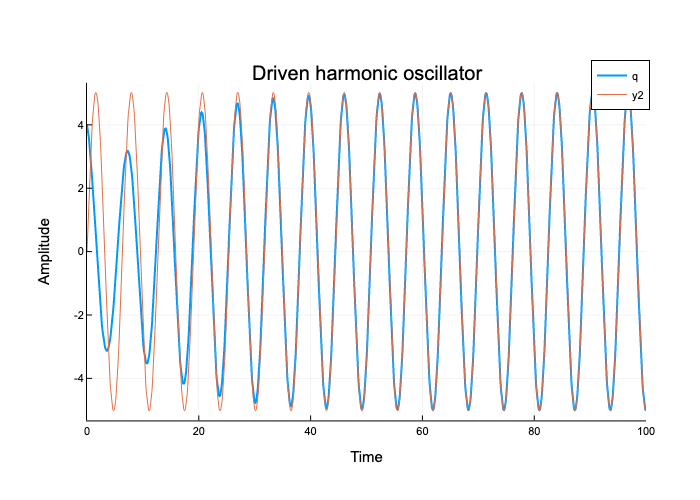

In [388]:
function drivenoscillator(du, u, p, t)
    q, dq  = u            # variables
    ω, m, F₀, ω₀, ζ = p   # parameters
    du[1] = dq
    du[2] = 1 / m * F₀ * sin(ω * t) - 2 * ζ * ω₀ * dq - ω^2 * q
end

# Initial Conditions
u₀ = [0, 4]

tspan = (0., 100.)

# Parameters
p = [.99, 1., 1., 1., .1]

# Pass to solvers
prob = ODEProblem(drivenoscillator, u₀, tspan, p)
sol = solve(prob, Tsit5())


# Plot
# plot(sol,linewidth=2,title ="Driven harmonic oscillator", xaxis = "Time", yaxis = "Amplitude", label = ["q" "dq"])
plot(sol, linewidth=2, title="Driven harmonic oscillator", xaxis="Time", yaxis="Amplitude", vars=[2,], label="q")

# plot(sol)
t = LinRange(tspan..., 1000)
plot!(t, [stady_state(p, ti) for ti in t])

# Appendix

In [ ]:

@parameters m k g
@variables t q[1:2](t) Dq[1:2](t)

∂_t = Differential(t); # define an operator for the differentiation w.r.t. time
D = Differential(t); # define an operator for the differentiation w.r.t. time

# LL(x,v) = 1/2*m*dot(v,v)-1/2*k*(sqrt(dot(x,x))-1.0)^2 - m*g*x[2]
LLL = 1/2 * m * dot(Dq, Dq) - 1/2 * k * (sqrt(dot(q, q)) - 1.0)^2 - m * g * q[2]




Lagrangian mechanics:

$$
\frac{\mathrm{d}}{\mathrm{d}t} \frac{\partial L}{\partial \dot{q}} = \frac{\partial L}{\partial q}
$$

In [ ]:
dLdq = [derivative(LLL, Q)  for Q in q]
dLdDq = [derivative(LLL, DQ)  for DQ in Dq]

dLdq
# dLdDq

In [ ]:
# harmonic oscillator
using Symbolics
using ModelingToolkit
using OrdinaryDiffEq

# define lagrangian
@variables t q q̇
@parameters m k
L = k*q^2/2 - m*q̇^2/2

# build euler lagrange equations
Dt = Differential(t)
res = Symbolics.derivative(L, q) - Dt(Symbolics.derivative(L, q̇))
@parameters t
@variables u(t)
res = substitute(res, q => u)
res = substitute(res, q̇ => Dt(u))
display(res)

@named sys = ODESystem([Dt(Dt((x))) ~ -(k/m)*x]) # works if I shuffle the Dt to lhs by hand
# sys = ODESystem([res ~ 0]) # fails

In [ ]:
using ModelingToolkit
using DifferentialEquations
using Plots

@variables t x(t) f(t) # independent and dependent variables

@parameters τ       # parameters
D = Differential(t) # define an operator for the differentiation w.r.t. time

# your first ODE, consisting of a single equation, indicated by ~
@named model = ODESystem(D(x) ~ (1 - x)/τ)
# @named model = ODESystem([f ~ sin(t), D(x) ~ (f - x)/τ])


prob = ODEProblem(model, [x => 0.0], (0.0,10.0), [τ => 3.0])
plot(solve(prob))

In [ ]:
@variables f(t)
@named fol_variable_f = ODESystem([f ~ sin(t), D(x) ~ (f - x)/τ])

prob = ODEProblem(structural_simplify(fol_variable_f), [x => 0.0], (0.0,10.0), [τ => 0.75])

sol = solve(prob)
plot(sol, vars=[x,f])

In [ ]:

@variables t x(t) # independent and dependent variables

@parameters τ       # parameters
D = Differential(t) # define an operator for the differentiation w.r.t. time

# your first ODE, consisting of a single equation, indicated by ~
# @named model = ODESystem(D(x) ~ (1 - x)/τ)
# @named model = ODESystem([f ~ sin(t), D(x) ~ (f - x)/τ])


# prob = ODEProblem(model, [x => 0.0], (0.0,10.0), [τ => 3.0])
# plot(solve(prob))


@named model = ODESystem([D(D(x)) ~ (sin(t) - x)/τ + D(x) ])

prob = ODEProblem(structural_simplify(model), [x => 0.0], (0.0,10.0), [τ => 0.75])
sol = solve(prob)
plot(sol)


In [ ]:
# Simple Harmonic Oscillator Problem
using OrdinaryDiffEq, Plots

#Parameters
ω = 1

#Initial Conditions
x₀ = [0.0]
dx₀ = [π/2]
tspan = (0.0, 2π)

ϕ = atan((dx₀[1]/ω)/x₀[1])
A = √(x₀[1]^2 + dx₀[1]^2)

#Define the problem
function harmonicoscillator(ddu,du,u,ω,t)
    ddu .= -ω^2 * u
end

#Pass to solvers
prob = SecondOrderODEProblem(harmonicoscillator, dx₀, x₀, tspan, ω)
sol = solve(prob, DPRKN6())

#Plot
plot(sol, vars=[2,1], linewidth=2, title ="Simple Harmonic Oscillator", xaxis = "Time", yaxis = "Elongation", label = ["x" "dx"])
plot!(t->A*cos(ω*t-ϕ), lw=3, ls=:dash, label="Analytical Solution x")
plot!(t->-A*ω*sin(ω*t-ϕ), lw=3, ls=:dash, label="Analytical Solution dx")

In [ ]:
@variables t x(t) RHS(t)  # independent and dependent variables
@parameters τ       # parameters
D = Differential(t) # define an operator for the differentiation w.r.t. time

# your first ODE, consisting of a single equation, indicated by ~
@named fol_separate = ODESystem([ RHS  ~ (1 - x)/τ,
                                  D(x) ~ RHS ])

using DifferentialEquations: solve
using Plots: plot

prob = ODEProblem(structural_simplify(fol_separate), [x => 0.0], (0.0,10.0), [τ => 3.0])
sol = solve(prob)
plot(sol, vars=[x,RHS])

In [ ]:
using ModelingToolkit, OrdinaryDiffEq

@parameters t σ ρ β
@variables x(t) y(t) z(t)
D = Differential(t)

eqs = [D(D(x)) ~ σ*(y-x),
       D(y) ~ x*(ρ-z)-y,
       D(z) ~ x*y - β*z]

       # sys = ODESystem([Dt(Dt((x))) ~ -(k/m)*x]) # works if I shuffle the Dt to lhs by hand
       # sys = ODESystem([res ~ 0]) # fails
       
       u0 = [
           x=>0
           ]
       tspan = (0.0,100.0)
       prob = ODEProblem(sys,u0,tspan,p,jac=true)
       sol = solve(prob,Tsit5())
@named sys = ODESystem(eqs)
sys = ode_order_lowering(sys)

u0 = [D(x) => 2.0,
      x => 1.0,
      y => 0.0,
      z => 0.0]

p  = [σ => 28.0,
      ρ => 10.0,
      β => 8/3]

tspan = (0.0,100.0)
prob = ODEProblem(sys,u0,tspan,p,jac=true)
sol = solve(prob,Tsit5())
using Plots; plot(sol,vars=(x,y))

In [ ]:


function L((v, ω), (x, θ), (Lₐ, Lₚ, mₖ, mₗ, mₚ, g), t)
    V = -mₚ*Lₚ*g*cos(θ)
    T = (mₖ+mₗ)*v^2/2 + mₚ*(Lₚ^2*ω^2 + 2*Lₚ*ω*v*cos(θ) + v^2)/2
    T - V
end


In [ ]:
a

In [ ]:

function lagrangian2system(
        L, q̇, q, p, t;
        Q = zeros(length(q)),
        defaults = [q̇; q] .=> 0.0,
        kwargs...
    )
    Q_vals = Q
    inds = eachindex(q)

    @variables v[inds] x[inds] Q[inds](t)
    sub = Base.Fix2(substitute, Dict(v.=>q̇, x.=>q))
    Lf = L(v, x, p, t)

    F = ModelingToolkit.gradient(Lf, x) + Q
    Lᵥ = ModelingToolkit.gradient(Lf, v)
    rhs = sub.(F - ModelingToolkit.jacobian(Lᵥ, x) * q̇ - ModelingToolkit.derivative.(Lᵥ, (t,)))
    M = sub.(ModelingToolkit.jacobian(Lᵥ, v))

    D = Differential(t)

    eqs = [
           D.(q̇) .~ M \ rhs
           D.(q) .~ q̇
           Q .~ Q_vals
          ]

    sys = ODESystem(eqs, t, [q̇; q; Q], p; defaults=defaults, kwargs...)
    return structural_simplify(sys)
end


In [ ]:
p = Dict(
    :Lₐ => 10,
    :Lₚ => 0.5,
    :mₖ => 100,
    :mₗ => 0,
    :mₚ => 25,
    :g => 9.80665
)

In [ ]:

# Cart input force
F = 1000 * sin(t)

# Generalized forces
Q = [F, 0]

# Make equations of motion
slosh_cart = lagrangian2system(L, [v, ω], [x, θ], [Lₐ, Lₚ, mₖ, mₗ, mₚ, g], t; Q)

# Initial Conditions
ic = [
    θ => deg2rad(10)
]

# # Parameters
# p = Dict(
#     Lₐ => 10,
#     Lₚ => 0.5,
#     mₖ => 100,
#     mₗ => 0,
#     mₚ => 25,
#     g => 9.80665
# )



In [ ]:

## Simulation
prob = ODEProblem(slosh_cart, ic, (0.0, 10.0), [p...])
sol = solve(prob, Tsit5())

In [ ]:
import Pkg; Pkg.add("Symbolics")

In [ ]:
using Symbolics
using ModelingToolkit
using OrdinaryDiffEq

# define lagrangian
@parameters m k
@variables t q q̇
LL = k*q^2/2 - m*q̇^2/2

# build euler lagrange equations
Dt = Differential(t)
res = Symbolics.derivative(LL, q) - Dt(Symbolics.derivative(LL, q̇))

@parameters t
@variables u(t)

res = substitute(res, q => u)
res = substitute(res, q̇ => Dt(u))
display(res)



In [ ]:
@variables x(t)

eqs = [Dt(Dt(x)) ~ -(k/m)*x]

In [ ]:
@named sys = ODESystem(eqs)

# sys = ODESystem([Dt(Dt((x))) ~ -(k/m)*x]) # works if I shuffle the Dt to lhs by hand
# sys = ODESystem([res ~ 0]) # fails

u0 = [
    x=>0
    ]
tspan = (0.0,100.0)
prob = ODEProblem(sys,u0,tspan,p,jac=true)
sol = solve(prob,Tsit5())

In [ ]:
using ModelingToolkit, OrdinaryDiffEq

@parameters t σ ρ β
@variables x(t) y(t) z(t)
D = Differential(t)

eqs = [D(D(x)) ~ σ*(y-x),
       D(y) ~ x*(ρ-z)-y,
       D(z) ~ x*y - β*z]

@named sys = ODESystem(eqs)
sys = ode_order_lowering(sys)

u0 = [D(x) => 2.0,
      x => 1.0,
      y => 0.0,
      z => 0.0]

p  = [σ => 28.0,
      ρ => 10.0,
      β => 8/3]

tspan = (0.0,100.0)
prob = ODEProblem(sys,u0,tspan,p,jac=true)
sol = solve(prob,Tsit5())
using Plots; plot(sol,vars=(x,y))